# Exploratory Data Analysis


## 1. Setup


### 1.1 Imports


In [27]:
from scripts.data_loader import load_data, split_features_targets
from scripts.preprocessor import remove_fillers, set_types, fill_missing, transform_data
from scripts.feature_analysis import (
    save_plots,
    plot_group_histogram,
    plot_group_boxplot,
    plot_group_line_chart,
    plot_group_spatial_heatmap,
    plot_spatial_heatmap,
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### 1.2 Loading Dataset


In [10]:
# Load data into DataFrames.
df = load_data("data")
df = remove_fillers(df)
df = fill_missing(df, "mean")
df = transform_data(df)
df = set_types(
    df,
    {
        "x": int,
        "y": int,
        "year": int,
        "ice_mask": int,
    },
)
print(f"📊 Data: \n {df.head()}\n")
features, targets = split_features_targets(df)
variables = [
    "air_temperature",
    "ocean_temperature",
    "precipitation",
    "ice_thickness",
    "ice_mask",
    "ice_velocity",
]
boundary_conditions = ["precipitation", "air_temperature", "ocean_temperature"]

📊 Data: 
      x   y  ice_thickness  ...  air_temperature  ocean_temperature  year
14 -11  25            0.0  ...         0.836595          -0.034495  2015
15 -10  25            0.0  ...         0.830760          -0.079245  2015
16  -9  25            0.0  ...         0.825038          -0.114335  2015
17  -8  25            0.0  ...         0.819387          -0.139854  2015
18  -7  25            0.0  ...         0.814295          -0.157410  2015

[5 rows x 9 columns]



c:\Users\samma\OneDrive\Documents\GitHub\SeaLevelAI\scripts\preprocessor.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna(-1)
c:\Users\samma\OneDrive\Documents\GitHub\SeaLevelAI\scripts\preprocessor.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ice_mask"] = df["ice_mask"].fillna(4)
c:\Users\samma\OneDrive\Documents\GitHub\SeaLevelAI\scripts\preprocessor.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

## 2. Feature Space


In [15]:
for feature in variables:
    save_plots(df, f"out/images/{feature}", feature)

### 2.0 Data Descriptions


In [12]:
# Describe the data.
print(f"📊 Data description: \n {df.describe()}\n")

📊 Data description: 
                  x            y  ...  ocean_temperature           year
count  194102.0000  194102.0000  ...      194102.000000  194102.000000
mean        0.0000       0.0000  ...           0.166677    2057.500000
std        13.4209      13.4209  ...           0.789064      24.824447
min       -25.0000     -25.0000  ...          -1.228246    2015.000000
25%       -11.0000     -11.0000  ...          -0.419754    2036.000000
50%         0.0000       0.0000  ...           0.000000    2057.500000
75%        11.0000      11.0000  ...           0.580246    2079.000000
max        25.0000      25.0000  ...           3.679689    2100.000000

[8 rows x 9 columns]



### 2.1 NaN Values


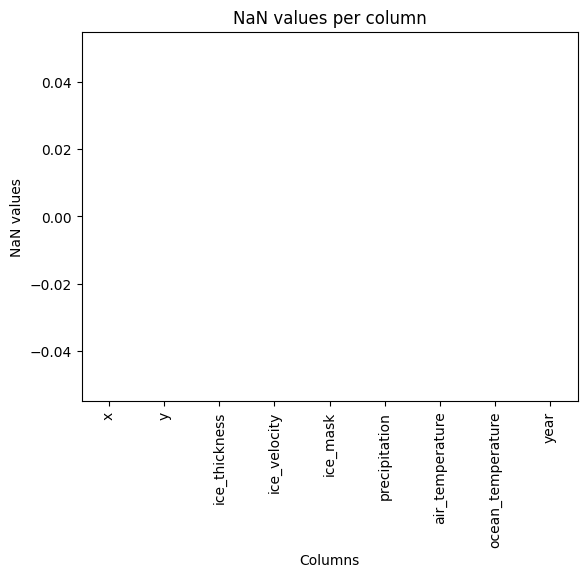

📊 NaN values per column: 
 x                    0
y                    0
ice_thickness        0
ice_velocity         0
ice_mask             0
precipitation        0
air_temperature      0
ocean_temperature    0
year                 0
dtype: int64

📊 NaN values proportion per column: 
 x                    0.0
y                    0.0
ice_thickness        0.0
ice_velocity         0.0
ice_mask             0.0
precipitation        0.0
air_temperature      0.0
ocean_temperature    0.0
year                 0.0
dtype: float64



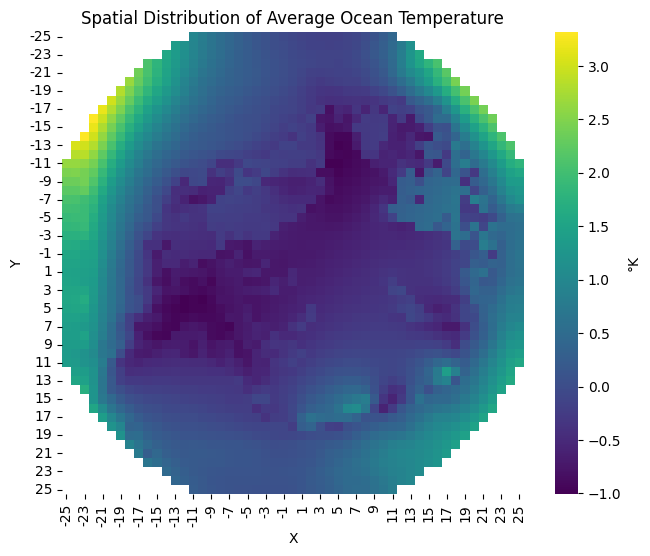

In [16]:
# Plot NaN values in each column
NaN_values = df.isna().sum()
sns.barplot(x=NaN_values.index, y=NaN_values.values)
plt.xticks(rotation=90)
plt.title("NaN values per column")
plt.xlabel("Columns")
plt.ylabel("NaN values")
plt.show()

print(f"📊 NaN values per column: \n {df.isna().sum()}\n")

# calculate each columns proportion of NaN values
NaN_proportion = df.isna().sum() / len(df)
print(f"📊 NaN values proportion per column: \n {NaN_proportion}\n")

# Plot a heatmap of NaN values
plot_spatial_heatmap(df, "ocean_temperature")

### 2.2 Outliers


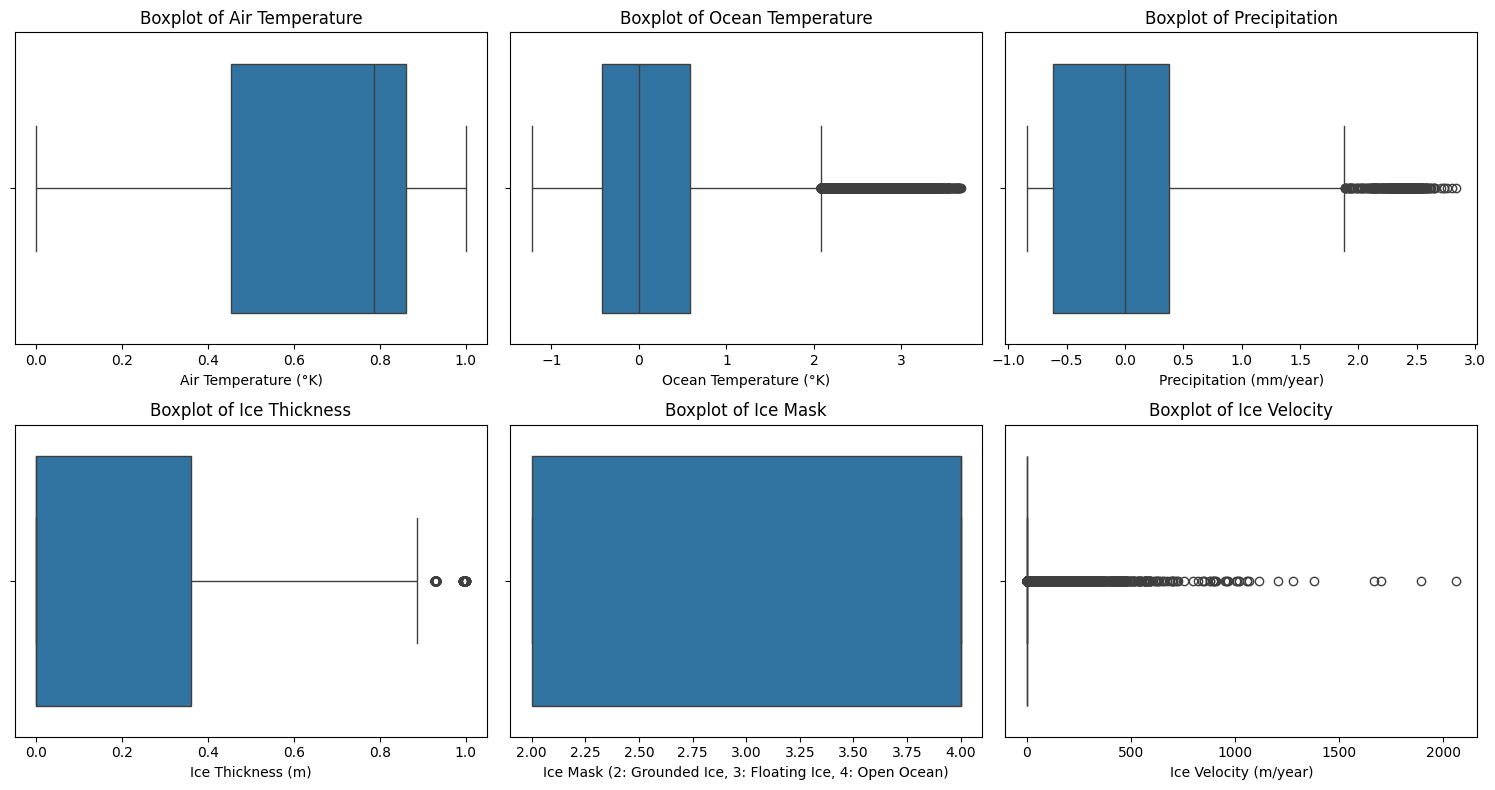

In [17]:
plot_group_boxplot(df, variables, 2, 3)

### 2.3 Duplicates


In [18]:
print(f"📊 Duplicates: {df.duplicated().sum()}")

📊 Duplicates: 0


### 2.4 Univariate Analysis


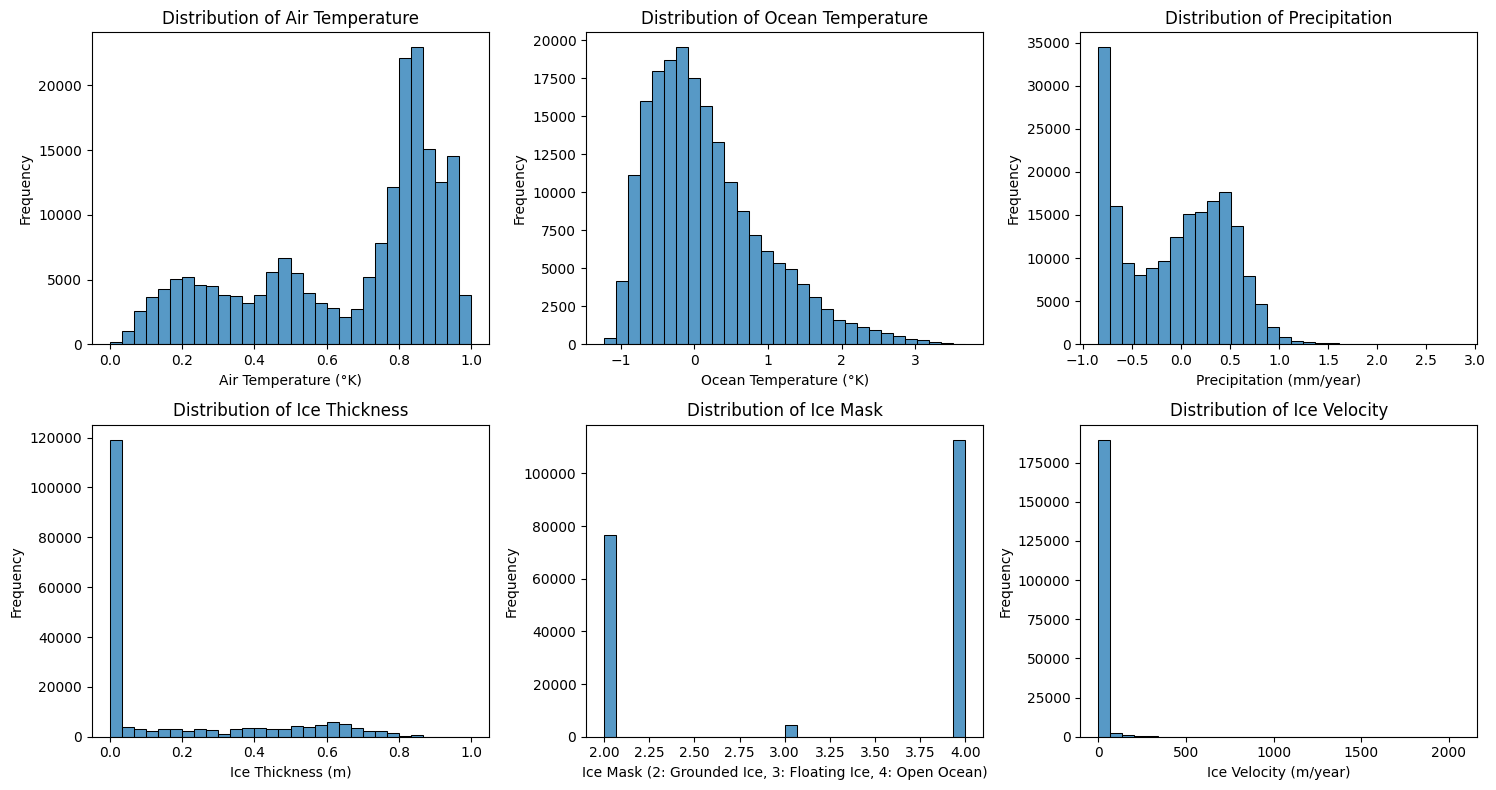

In [19]:
plot_group_histogram(df, variables, 2, 3)

### 2.5 Static Spatial Representations


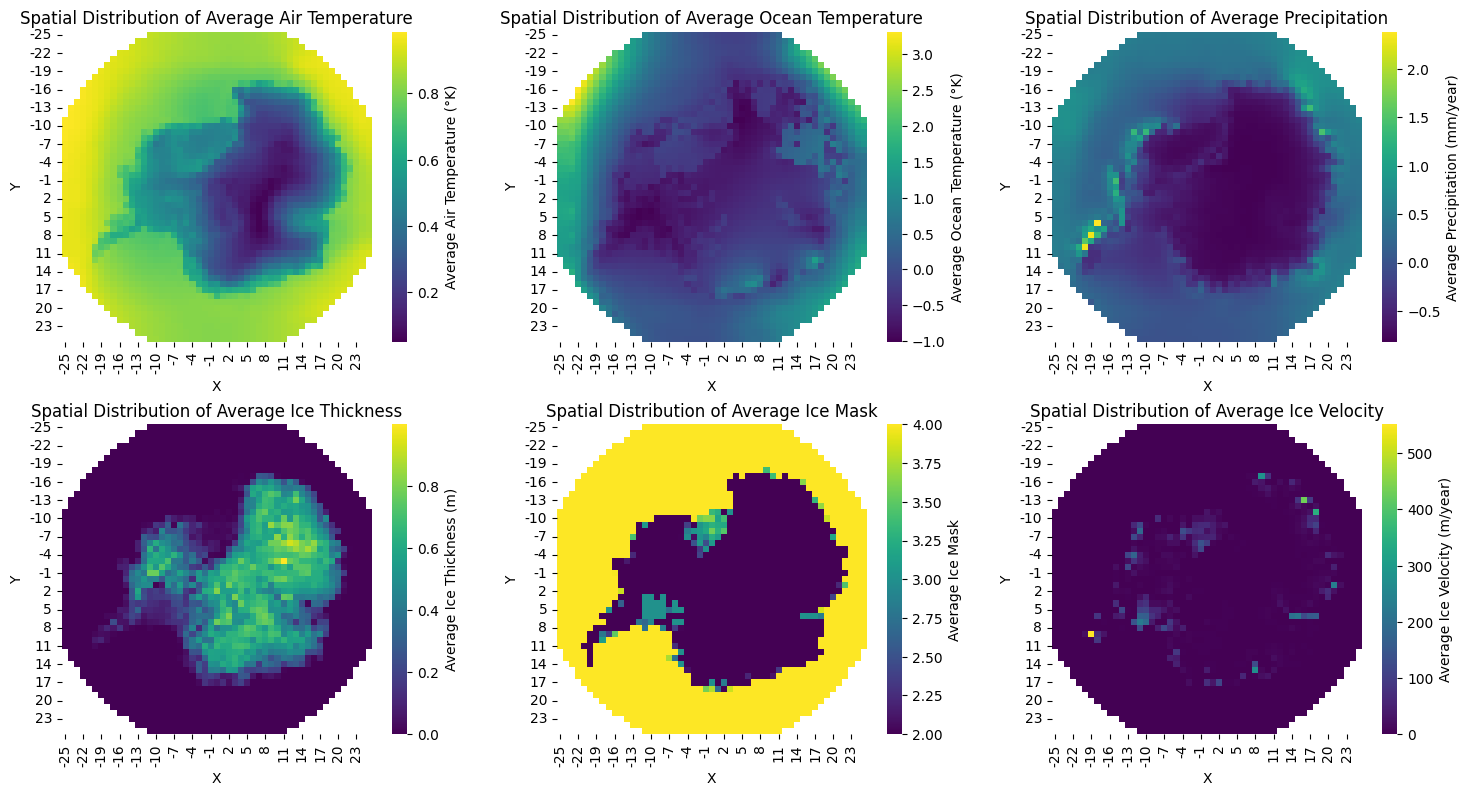

In [21]:
plot_group_spatial_heatmap(df, variables, 2, 3)

### 2.6 Dynamic Spatial Representations


In [ ]:
for feature in variables:
    #create_heatmap_gif(df, feature)

### 2.7 Temporal Representations


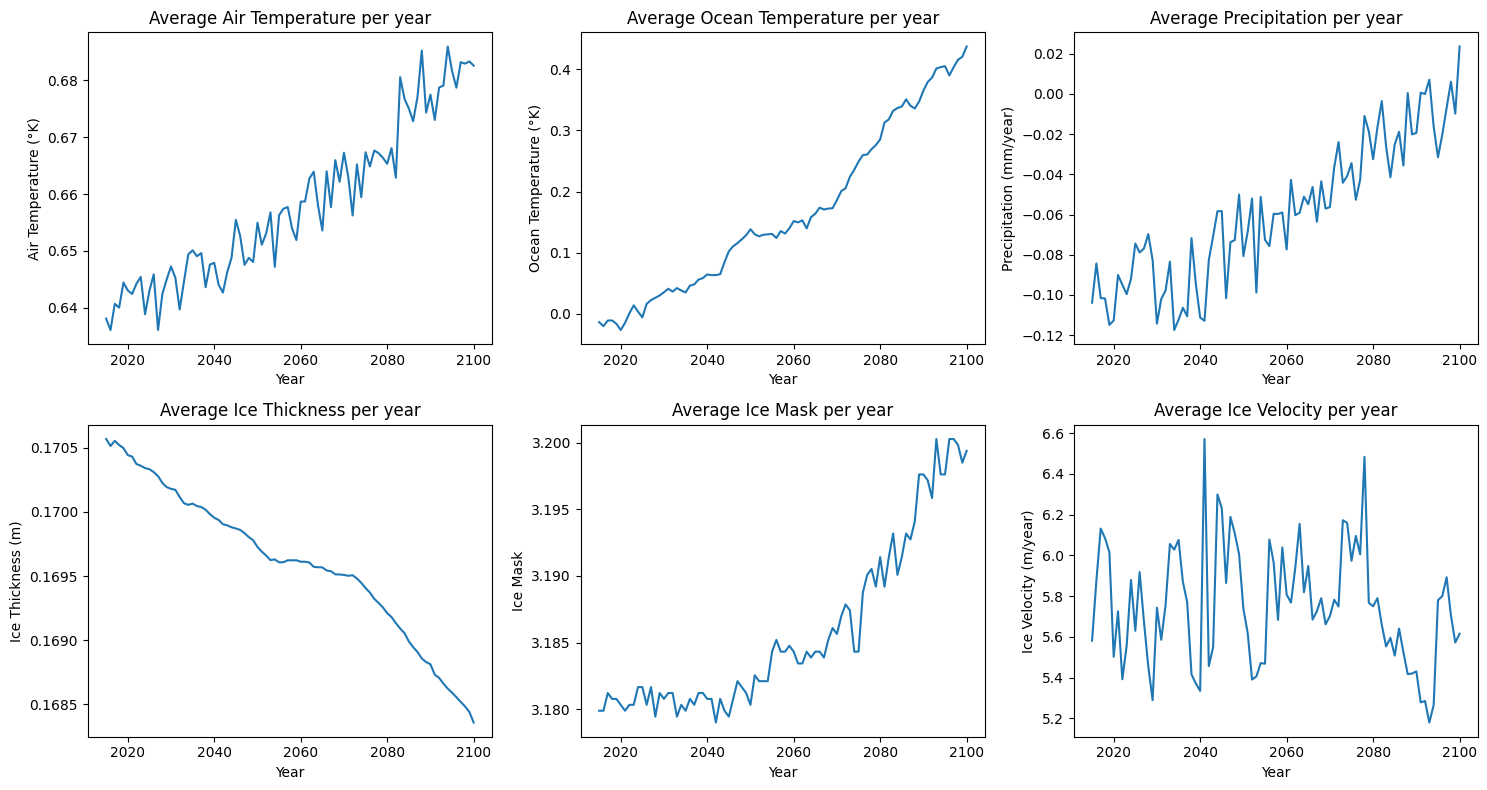

In [24]:
plot_group_line_chart(df, variables, 2, 3)

## 3. Correlation Analysis


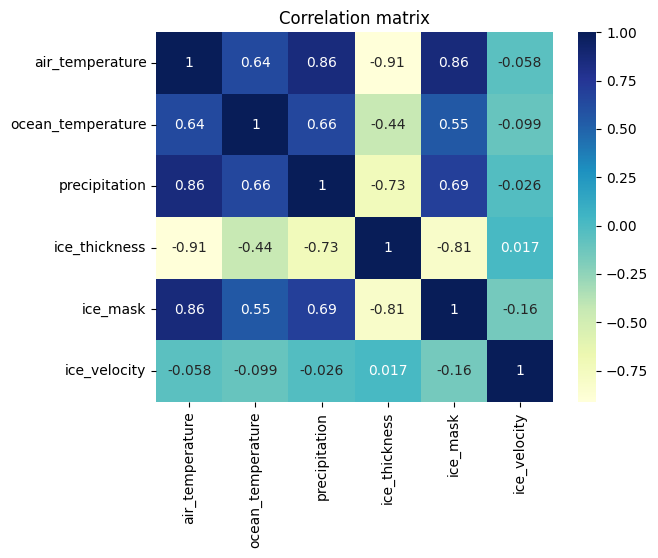

In [25]:
# Plot a correlation matrix
corr = df[variables].corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation matrix")
plt.show()

## 3. Feature Engineering


### 3.2 Feature Creation


In [28]:
created_features = []

# Distance to Pole
df["dtp"] = np.sqrt(df["x"] ** 2 + df["y"] ** 2)
created_features.append("dtp")

# Rolling Standard Deviation
for feature in ["precipitation", "air_temperature"]:
    df[f"{feature}_rolling_std"] = df[feature].rolling(window=3).std()
    created_features.extend([f"{feature}_rolling_std"])

# Log Transformation of air_temperature
df["log_air_temperature"] = np.log(df["air_temperature"] + 1)
created_features.append("log_air_temperature")

### 3.3 Created Feature Analysis


          dtp  precipitation_rolling_std  ...  temp_diff  log_air_temperature
14  27.313001                        NaN  ...   0.871089             0.607913
15  26.925824                        NaN  ...   0.910005             0.604731
16  26.570661                   0.023983  ...   0.939374             0.601601
17  26.248809                   0.013944  ...   0.959240             0.598499
18  25.961510                   0.010065  ...   0.971705             0.595697

[5 rows x 5 columns]


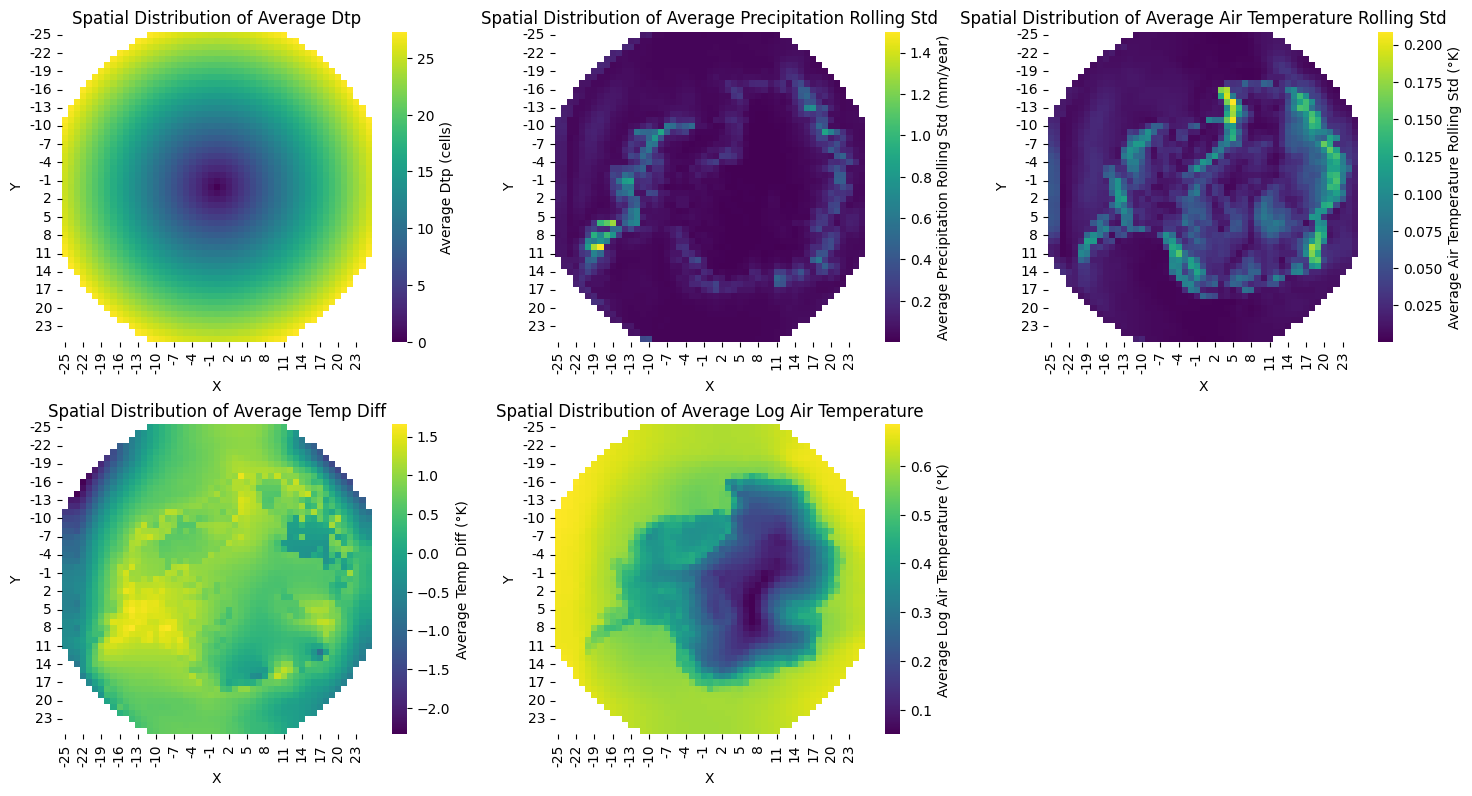

In [29]:
df_created = df[created_features]
print(df_created.head())

plot_group_spatial_heatmap(df, created_features, 2, 3)

### 3.4 Created Feature Correlation Analysis


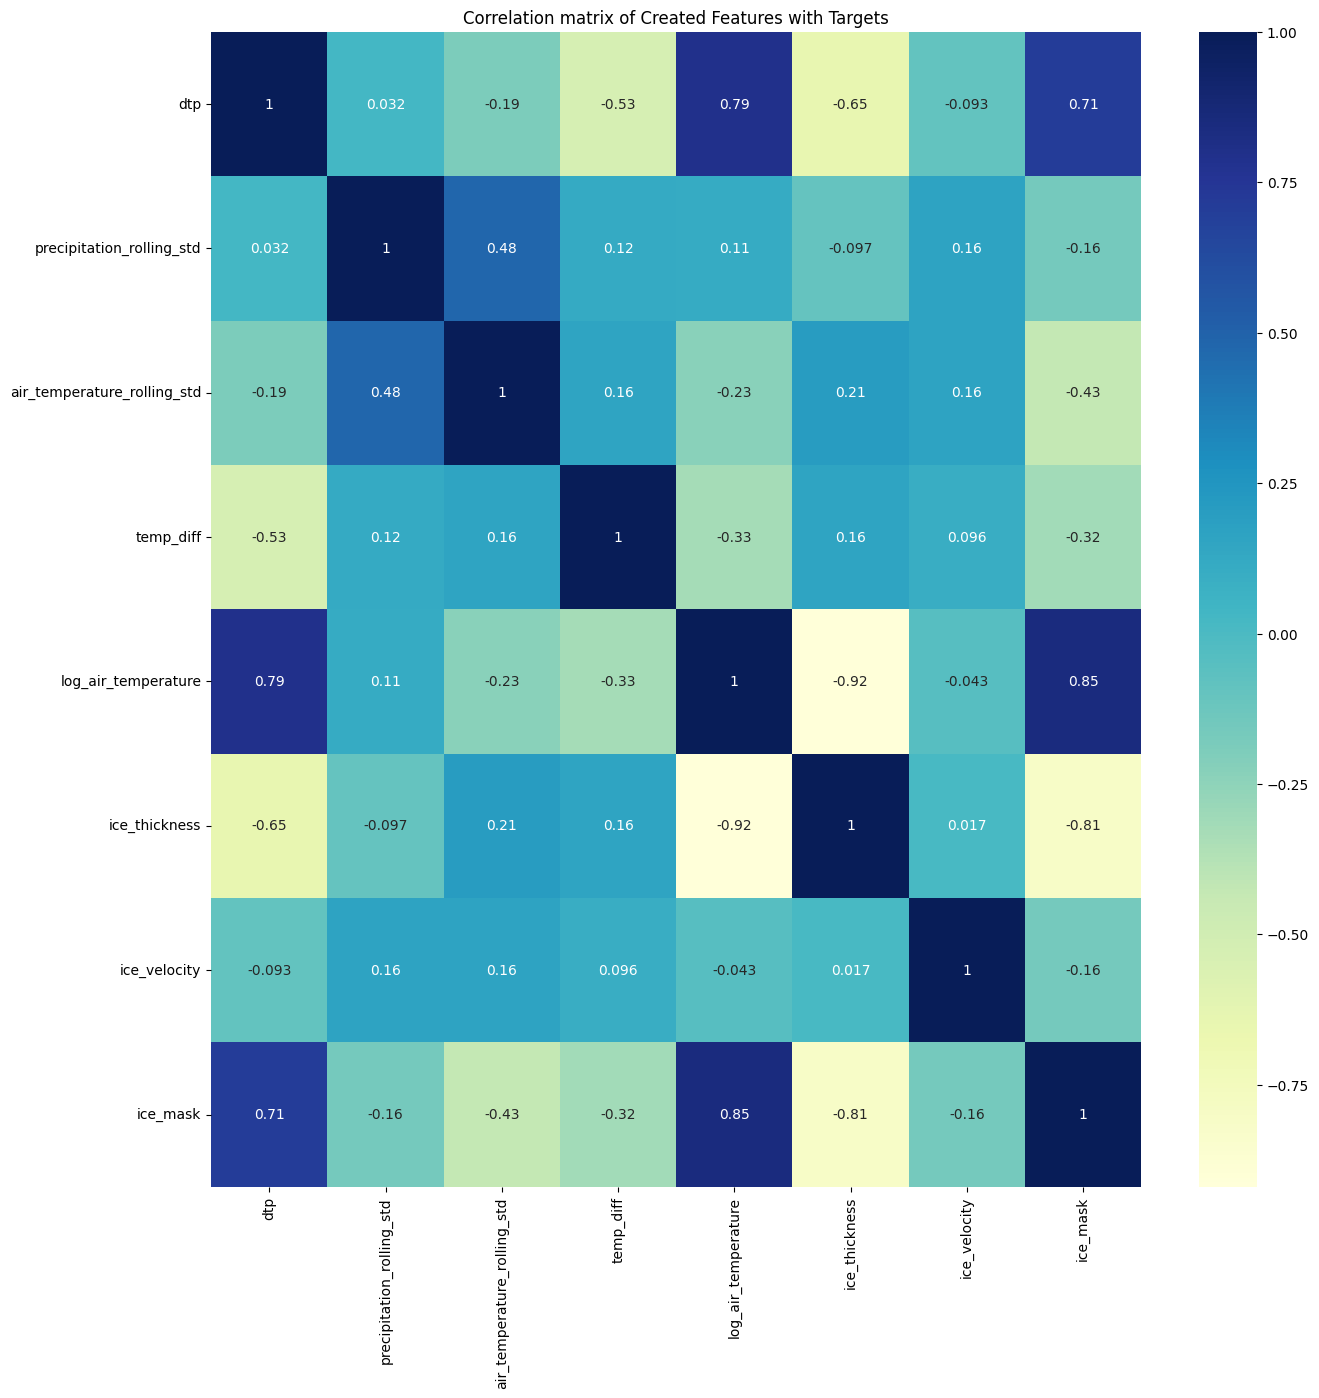

In [30]:
created_with_targets = created_features + targets.columns.tolist()
corr = df[created_with_targets].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation matrix of Created Features with Targets")
plt.show()